# Disaster Tweet Classification 
Problem Statement - The disaster relief organization which relies on twitter as an important medium for communication need to identify if a tweet related to a actual disaster. Since tweets can be misleading at times as Users tend to use words associated to disasters to describe or point towards something trivial or something unsuccessful / exteremely bad.


## Importing the Required Libraries

In [1]:
import pandas as pd 
import numpy as np

import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

plt.style.use('ggplot')

## Dataset Exploration

In [2]:
tweet = pd.read_csv('tweet2.csv', encoding = 'latin-1')
tweet.head()

,id,text,label
0,0.0,My mom is setting a bathroom curfew https://t....,0.0
1,1.0,Governments everywhere continue to behave as i...,0.0
2,2.0,The state has made several big interventions a...,0.0
3,3.0,A system built on slavery from you feeling a s...,0.0
4,4.0,Why do I tweet? Because the mainstream media i...,0.0


In [3]:
tweet.shape

(5105, 3)

In [4]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5105 entries, 0 to 5104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      5101 non-null   float64
 1   text    5101 non-null   object 
 2   label   5101 non-null   float64
dtypes: float64(2), object(1)
memory usage: 119.8+ KB


In [5]:
tweet['text'].isnull().sum()

4

In [6]:
tweet.dropna(subset=['text','label'], inplace=True)

In [7]:
tweet['label'] = tweet['label'].astype(int)

In [8]:
tweet.head()

,id,text,label
0,0.0,My mom is setting a bathroom curfew https://t....,0
1,1.0,Governments everywhere continue to behave as i...,0
2,2.0,The state has made several big interventions a...,0
3,3.0,A system built on slavery from you feeling a s...,0
4,4.0,Why do I tweet? Because the mainstream media i...,0


## Exploratory Data Analysis

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 120


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


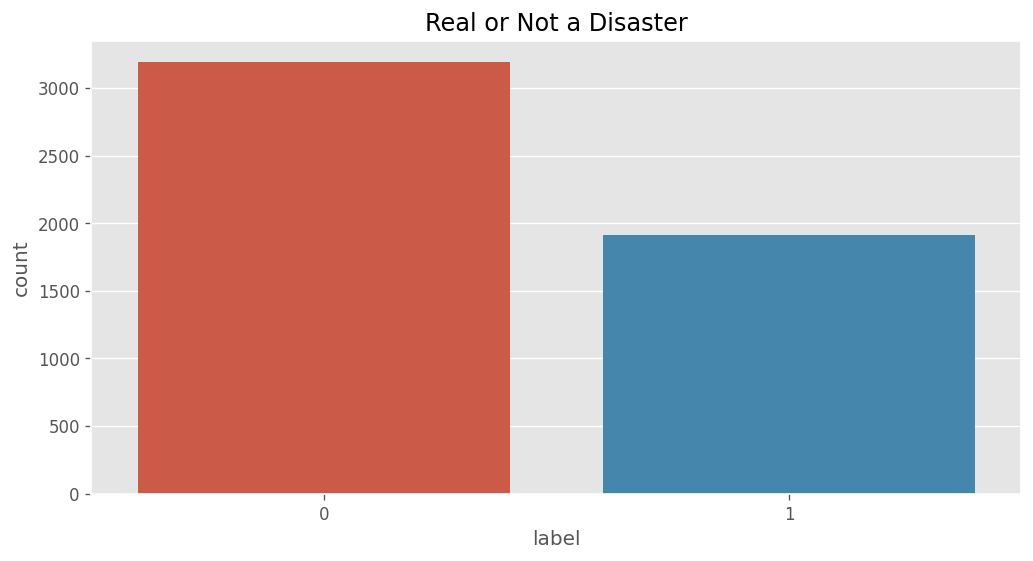

In [10]:
sns.countplot('label', data=tweet)
plt.title('Real or Not a Disaster')
plt.show()

In [11]:
tweet.label.value_counts()

0    3191
1    1910
Name: label, dtype: int64

### About 63% of datapoints indicate Non Disaster events and 37% of the data point towards a Disastorous event. 

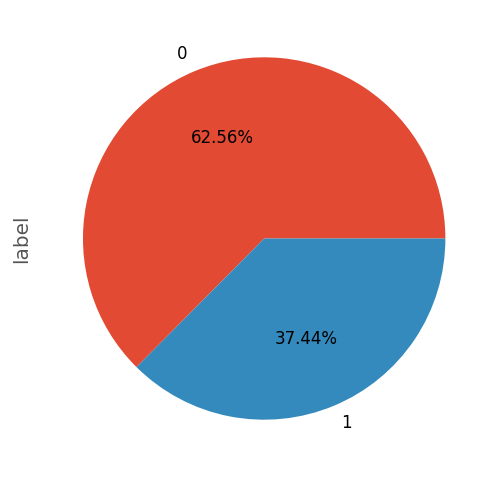

In [12]:
tweet['label'].value_counts().plot.pie(autopct = '%1.2f%%')

### Before proceeding to Data preprocessing and Cleaning we need to make sure that the text document is in lowercase as a vocabulary is formed of all the unique words in all the documents. The vocabulary acts as a feature vector.

In [13]:
tweet['text'] = tweet['text'].str.lower()
tweet.head()

,id,text,label
0,0.0,my mom is setting a bathroom curfew https://t....,0
1,1.0,governments everywhere continue to behave as i...,0
2,2.0,the state has made several big interventions a...,0
3,3.0,a system built on slavery from you feeling a s...,0
4,4.0,why do i tweet? because the mainstream media i...,0


In [14]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-8pllpwgs
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-8pllpwgs
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=11756 sha256=54c9926480415fc0869505129b2b96ccf17e1c9903bb81e4d65a54c4785d6ff4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wk5fhbzj/wheels/0d/b3/29/bfe3deffda68980088d17b81331be6667e837ffb4a071bae82
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


In [15]:
import preprocess_kgptalkie as kgp

In [16]:
tweets = kgp.get_basic_features(tweet)
tweets.head()

,id,text,label,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,0.0,my mom is setting a bathroom curfew https://t....,0,52,8,6.500000,3,0,0,2,0
1,1.0,governments everywhere continue to behave as i...,0,101,20,5.050000,10,0,0,1,0
2,2.0,the state has made several big interventions a...,0,105,19,5.526316,8,0,0,2,0
3,3.0,a system built on slavery from you feeling a s...,0,96,18,5.333333,8,0,0,2,0
4,4.0,why do i tweet? because the mainstream media i...,0,101,20,5.050000,11,0,0,1,0


### From the plot below, It can be seen that most of the tweets are about 100-120 characters or words long.

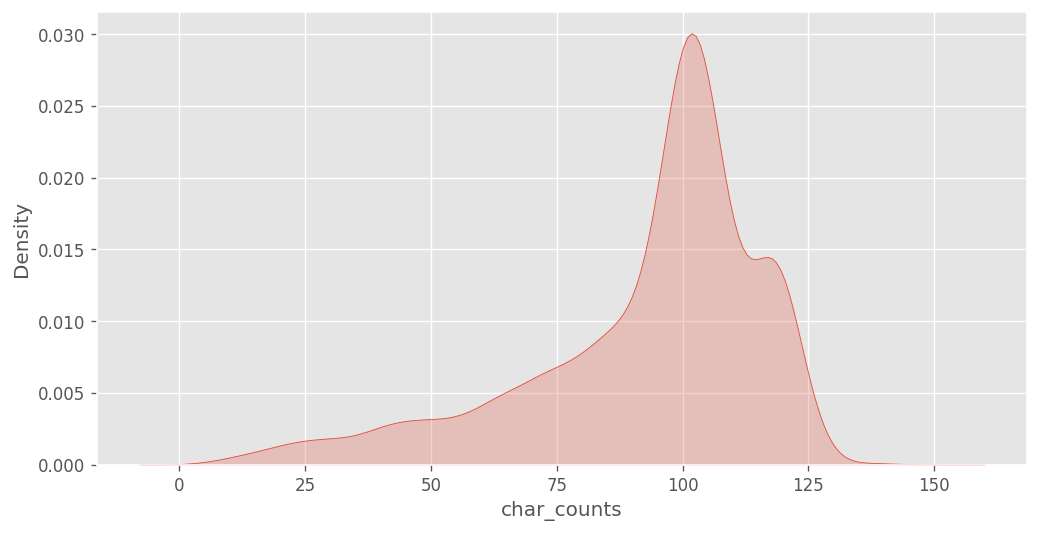

In [18]:
sns.kdeplot(tweet['char_counts'], shade=True)

### Disaster tweets tends to have ***15% more word characters*** than that of Non Disaster tweets.

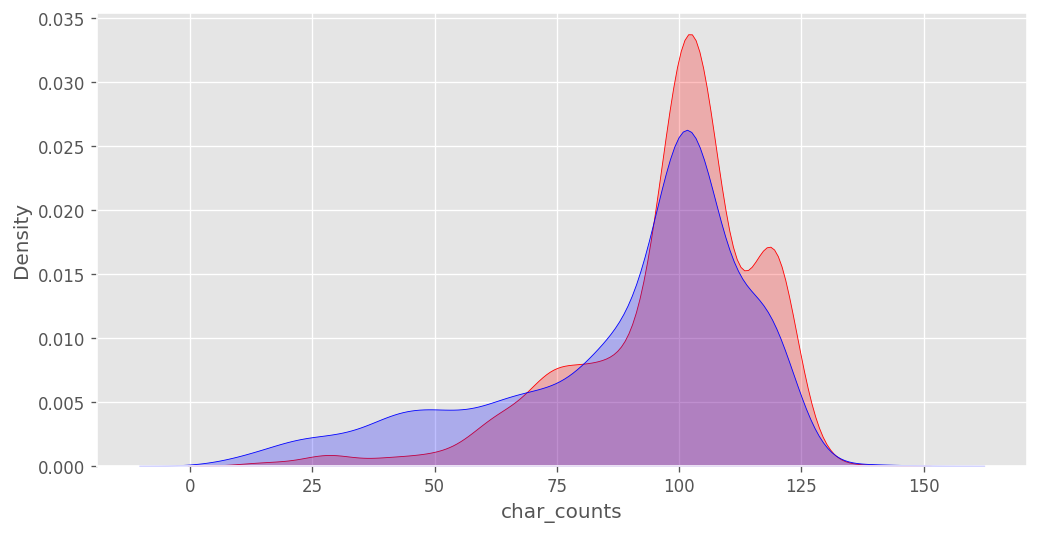

In [19]:
sns.kdeplot(tweet[tweet['label']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['label']==0]['char_counts'], shade=True, color='blue')

### The Violin plot suggests that tweets which represent disasters tend to have more words present in the tweet in comparision, which seems logical as the people would try to articulate the disasterous event with more words.

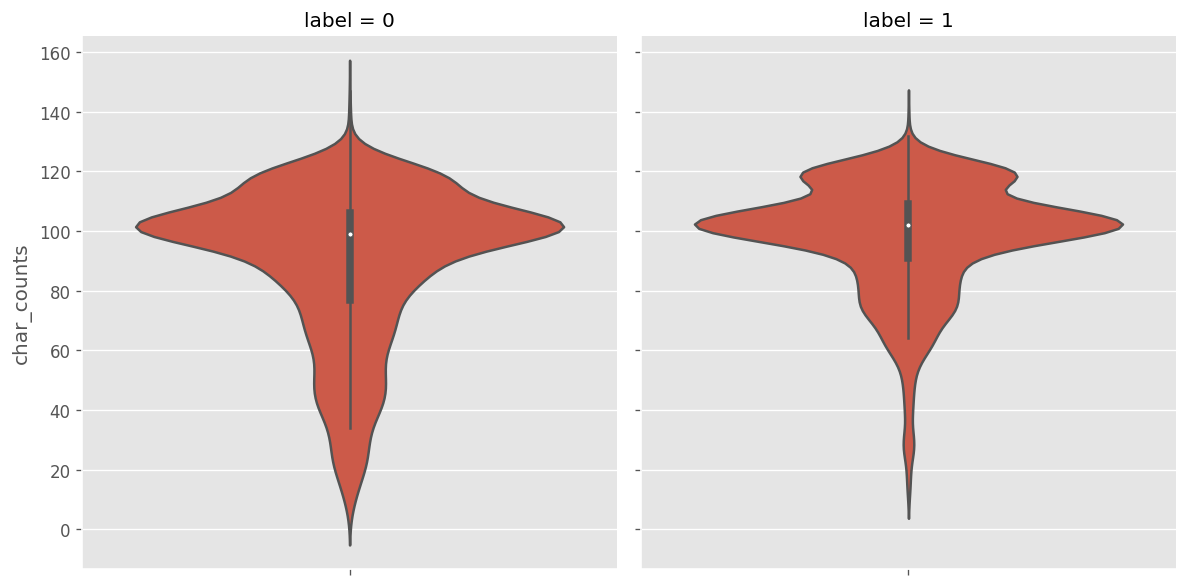

In [20]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='label')

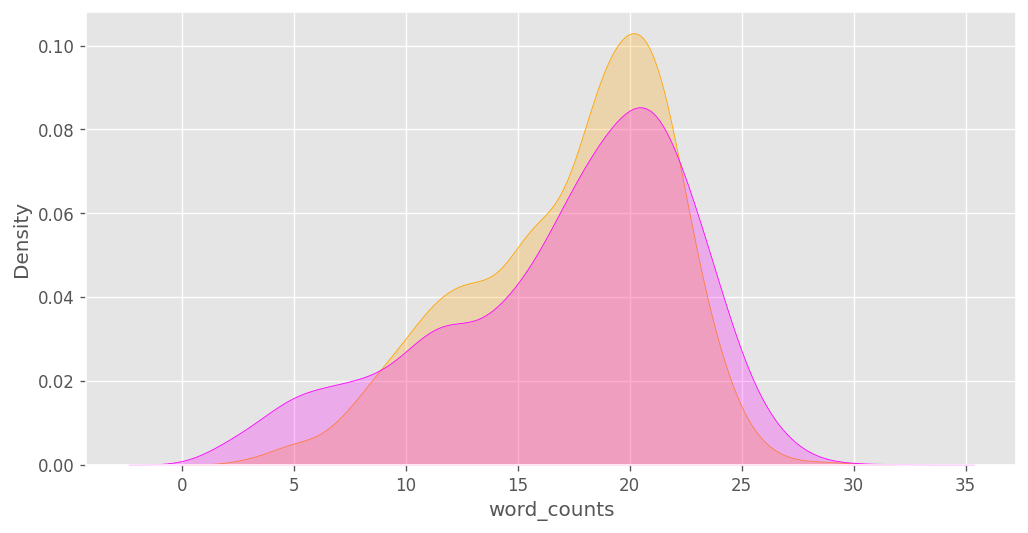

In [21]:
sns.kdeplot(tweet[tweet['label']==1]['word_counts'], shade=True, color='orange')
sns.kdeplot(tweet[tweet['label']==0]['word_counts'], shade=True, color='magenta')

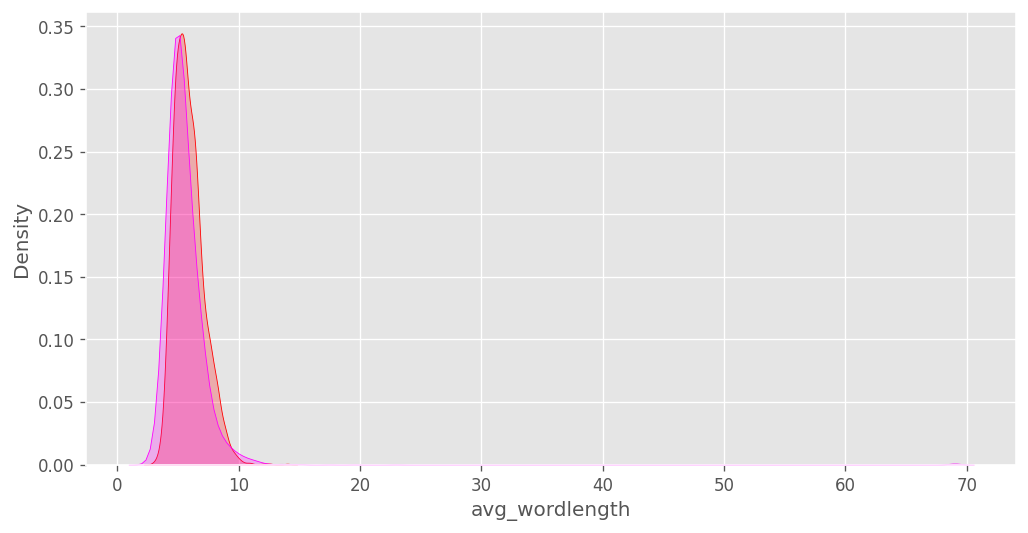

In [22]:
sns.kdeplot(tweet[tweet['label']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['label']==0]['avg_wordlength'], shade=True, color='magenta')

### This plot represents the Stopwords count for Disaster and Non disaster tweets 

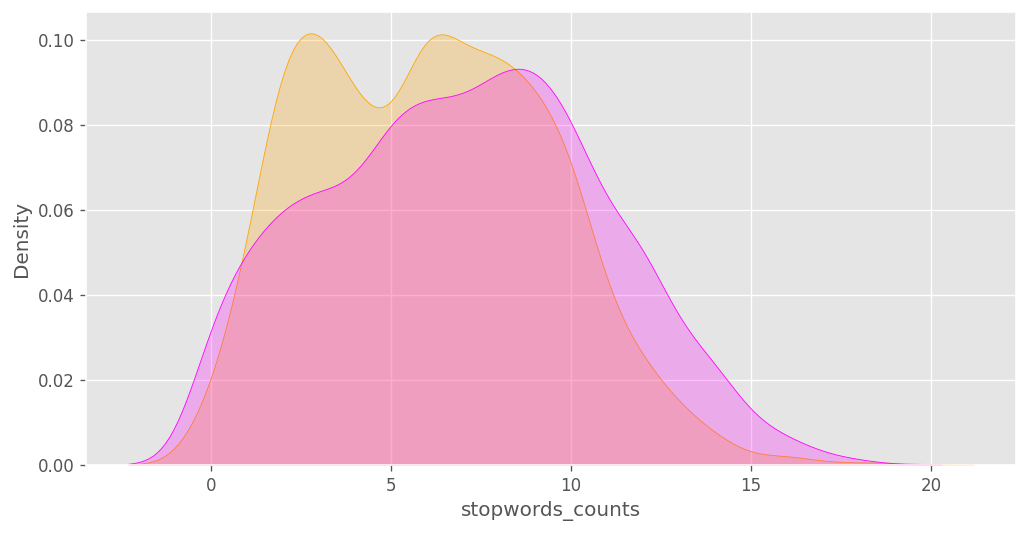

In [23]:
sns.kdeplot(tweet[tweet['label']==1]['stopwords_counts'], shade=True, color='orange')
sns.kdeplot(tweet[tweet['label']==0]['stopwords_counts'], shade=True, color='magenta')

## Data Cleaning 
Here we are going to remove the stopwords, punctuations, website links, html tags and any special characters which don't provide any information whether a event is a Disaster or not.

In [26]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [27]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [28]:
# Here we get rid of short words or words with less than 3 characters
tweet['text'] = tweet['text'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3])) 

In [29]:
tweet.head()

,id,text,label,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,0.0,setting bathroom curfew,0,52,8,6.500000,3,0,0,2,0
1,1.0,governments everywhere continue behave nothing...,0,101,20,5.050000,10,0,0,1,0
2,2.0,state made several interventions across electr...,0,105,19,5.526316,8,0,0,2,0
3,3.0,system built slavery from feeling strong sense...,0,96,18,5.333333,8,0,0,2,0
4,4.0,tweet because mainstream media ignoring financ...,0,101,20,5.050000,11,0,0,1,0


### This Plot indicates the Top 20 Frequent words used in Tweets

In [30]:
freqs = kgp.get_word_freqs(tweet, 'text')

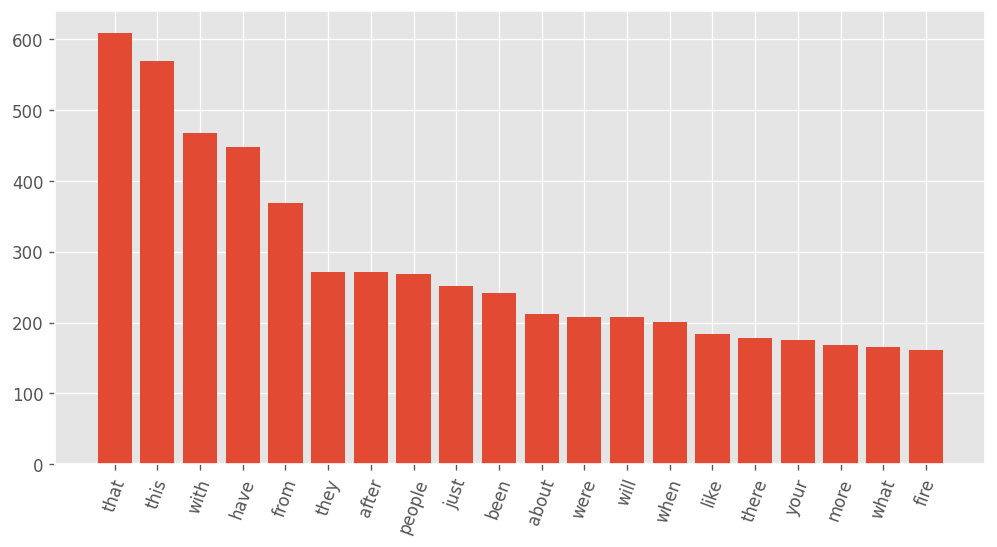

In [31]:
top20 = freqs[:20]
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

## Disaster Words Visualization with WordCloud 

In [33]:
real = kgp.get_word_freqs(tweet[tweet['label']==1], 'text')
real = ' '.join(real.index)
real

'from have after that with this been people were fire killed over thunderstorm they iran there just more train volcano news severe australia collision china sinkhole attack about road taal emergency their warning down least dead fires police home today services swallows freight between near derailment alert eruption morning earthquake many years until into hitchin since will suicide when nuclear body some south death first last died found storm chemical north under weather during woman injured year very tornado heavy including time still update another avalanche days across 2020 crash philippines derailed smoke ukrainian buildings than reported incident puerto parts january months military australian which several bombing accident disaster rescued killing before rico being kashmir shot british outbreak arrested hazardous county area houses iranian huge miles rescue thailand rain prime island caused ground traffic pakistan what left missing bomb thousands base quarantined minister dubli

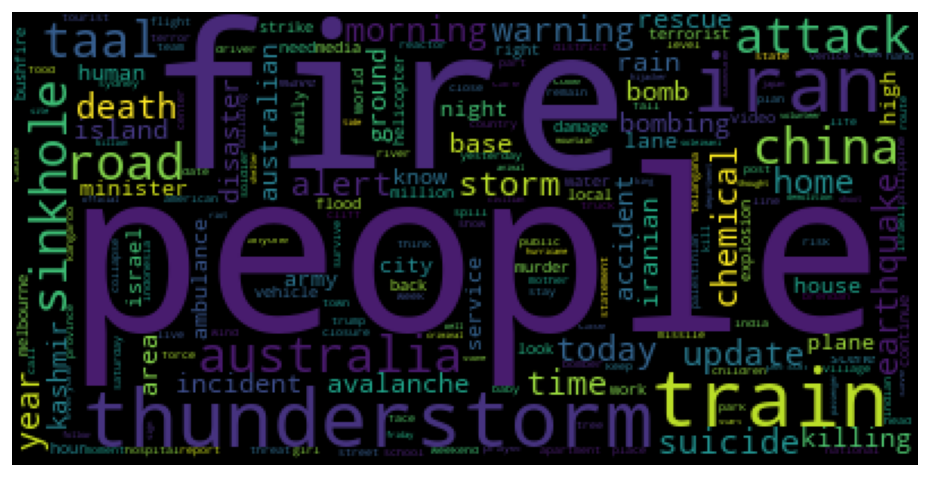

In [34]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [35]:
nreal = kgp.get_word_freqs(tweet[tweet['label']==0], 'text')
nreal = ' '.join(nreal.index)
nreal

'that this with have they from just will like when your about people what would body there been more their after were burning know need time over only before back should into being them because down could think some death buildings trump fire battle fires years attack blood want where collapse these army today many world first then iran really dead bags does much good still demolish blew bush bloody demolition never here please right collided said well same those curfew which than damage deaths deluge very love collide blazing also fall climate since demolished dont catastrophic bombing house most another attacked state accident government bleeding crush cannot while bomb youre again make point even 2020 emergency made nothing always bioterrorism every danger remember annihilated airplane life help cliff destroy someone going around crash video against once crushed come australia read work last media home bridge casualty arson keep derailed year saying next collapsed ever needs part gr

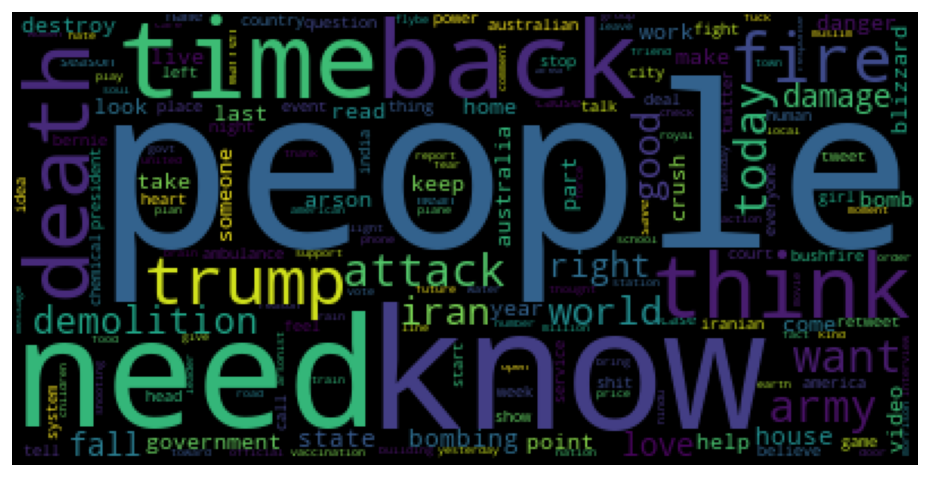

In [36]:
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF

TF-IDF means Term Frequency - Inverse Document Frequency. This is a statistic that is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
text = tweet['text']
y = tweet['label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(text, y, test_size = 0.3, random_state=0)

In [40]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(text)
X_train_Tfidf = Tfidf_vect.transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

In [41]:
def run_Model(clf, X_train_Tfidf, X_test_Tfidf, y_train, y_test):
  clf.fit(X_train_Tfidf, y_train)
  y_pred = clf.predict(X_test_Tfidf)
  

  print(clf.score(X_test_Tfidf, y_test))
  print('Classification Report')
  print(classification_report(y_test, y_pred))

## Naive Bayes

In [42]:
from sklearn import model_selection,naive_bayes

In [43]:
clf = naive_bayes.MultinomialNB()

In [44]:
run_Model(clf, X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.8576094056172436
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       954
           1       0.92      0.68      0.78       577

    accuracy                           0.86      1531
   macro avg       0.88      0.82      0.84      1531
weighted avg       0.87      0.86      0.85      1531



## Logistics Regression

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
clf = LogisticRegression(C=1e5)

In [47]:
run_Model(clf, X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.8680600914435009
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       954
           1       0.86      0.78      0.82       577

    accuracy                           0.87      1531
   macro avg       0.87      0.85      0.86      1531
weighted avg       0.87      0.87      0.87      1531



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


## ExtraTreeClassifier

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

In [49]:
clf = ExtraTreesClassifier(n_estimators = 19, bootstrap = True, random_state=9)

In [50]:
run_Model(clf,X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.8458523840627041
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       954
           1       0.90      0.66      0.76       577

    accuracy                           0.85      1531
   macro avg       0.86      0.81      0.82      1531
weighted avg       0.85      0.85      0.84      1531



## Random Forest Classifier





In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
clf = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=9)

In [53]:
run_Model(clf,X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.8536903984323971
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       954
           1       0.89      0.69      0.78       577

    accuracy                           0.85      1531
   macro avg       0.87      0.82      0.84      1531
weighted avg       0.86      0.85      0.85      1531



## Linear SVM

In [54]:
from sklearn.svm import LinearSVC

In [55]:
clf = LinearSVC()
run_Model(clf,X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.8791639451338994
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       954
           1       0.90      0.77      0.83       577

    accuracy                           0.88      1531
   macro avg       0.88      0.86      0.87      1531
weighted avg       0.88      0.88      0.88      1531



## AdaBoost Classifier

In [56]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [57]:
clf = AdaBoostClassifier(n_estimators=19)

In [58]:
run_Model(clf,X_train_Tfidf, X_test_Tfidf, y_train, y_test)

0.7380796864794252
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.90      0.81       954
           1       0.74      0.47      0.57       577

    accuracy                           0.74      1531
   macro avg       0.74      0.69      0.69      1531
weighted avg       0.74      0.74      0.72      1531

